# Neural Network for Numerical Integration on the Reaction Diffusion System

This notebook contains the solution to part (a), (b) and (c) of exercise 6.1 for the KS equations.

## (a) 

**Reaction–diffusion systems** are mathematical models which correspond to several physical phenomena. Mathematically, reaction–diffusion systems take the form of semi-linear parabolic partial differential equations. They can be represented in the general form:

$$ \partial_t \vec{q} = D \nabla^2 \vec{q}  +  \vec{R}(\vec{q}) $$

where $\vec{q}(x, t)$ represents the unknown vector function, $D$ is a diagonal matrix of diffusion coefficients, and $\vec{R}$ accounts for all local reactions. 

In [1]:
# Import the necessary libraries.
import numpy as np
import scipy.io
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import time

# Import plotting libraries and tools.
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

 ## Dataset
 
 The dataset is composed of $201$ frames (temporal dimension) with $(251 \times 251)$ pixels each (space dimension). The dependent variables of the problem, whose dynamic is collected in the aforementioned frameworks, are $U$ and $V$; in the following we will analyse only $U$, which is represented in the video below.
 
While we dedicated exercise 6.1 with the Kuramoto–Sivashinsky to compare the performances of two neural networks ( RNN and FFNN), we will implement here only the case of FFNN, because it matches better what was required from the exercise, in addition, to make the exercise more compact, we will only explore the casistic $\Delta T = 1$; then, given $\Delta T$:

- The network takes as input a single snips at time $j$, $U^{(j)}\in\,M(251\times 251)$.
- The network is required to predict $U^{(j+\Delta T)}\in\,M(251\times 251)$.
 

Import and plot the dataset.

In [2]:
# Import data.

# get the right path to the data.
data_path = os.path.join( os.path.abspath("") , "..\DATA\\reaction_diffusion_big.mat" )

# load the data.
data = scipy.io.loadmat( data_path )

# assign the problem variables.
T = data["t"].squeeze()
X = data["x"].squeeze()
Y = data["y"].squeeze()
U = data["u"]
T_dim = len(T)
X_dim = len(X)
Y_dim = len(Y)

FileNotFoundError: [Errno 2] No such file or directory: '/home/nrosi/NRprojects/Scientific-Machine-Learning/Exercise 6.1/..\\DATA\\reaction_diffusion_big.mat'

In [3]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from mpl_toolkits.axes_grid1 import make_axes_locatable

# First set up the figure, the axis, and the plot element we want to animate
def animate_flow( arr , dims , video_name , t = 10 ):
    n, m = dims
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), sharex=True, sharey=True)
    fig.set_size_inches(n/120, m/120) # sets size relative to image size

    pos = ax.imshow(arr.reshape(n, m, arr.shape[-1], order='C')[:,:,0].T, 
                    cmap='RdBu_r',
                    vmin= U.min(),
                    vmax= U.max())

    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')
    cb = fig.colorbar(pos, cax=cax)
    total_frames = arr.shape[-1]

    # animation function.  This is called sequentially
    def animate(i):
        pos.set_array(arr.reshape(n, m, arr.shape[-1], order='C')[:,:,i].T)
        cax.cla()
        fig.colorbar(pos, cax=cax)
        return pos
        
    anim = FuncAnimation(fig, animate, frames=total_frames, interval=5)
    anim.save(video_name, fps=total_frames/t, extra_args=['-vcodec', 'libx264'])
    plt.close()

video_name = 'Initial_data_RD.mp4'
animate_flow( U , ( U.shape[0] , U.shape[1] ) , video_name )

NameError: name 'U' is not defined

Link to the video: [Reaction Diffusion dynamic, raw data](https://youtube.com/shorts/9VoTKmVImlo?feature=share)

Prepare the input and output dataset; the input dataset contains the first $(0:201 - \Delta T)$ snips, while the output dataset contains the last $(\Delta T:201)$ snips. 

In [4]:
# Choose a DELTA T (from 0 to 251)
DT = 1

# divide the dataset between input (past) and output (future).
UIN = U[ : , : , :( T_dim - DT ) ]
UOUT = U[ : , : , DT : ( T_dim ) ] 

dataset_len = T_dim - DT

UIN = UIN.reshape( X_dim * Y_dim , dataset_len )
UOUT = UOUT.reshape( X_dim * Y_dim , dataset_len )

NameError: name 'U' is not defined

Once the input and output datset are created, they are shuffled and divided into the **training**, **validation** and **test sets**. 

In [5]:
# Divide the dataset between trining, validation and test sets.
train_len = int( dataset_len  * 0.8 )
val_len = int( dataset_len  * 0.1 )
test_len = int( dataset_len  * 0.1 )

# Random shuffle to select the pairs non-sequentially.
idx = np.random.choice( dataset_len , dataset_len , replace = False )
idx_train = idx[ 0 : train_len ]
idx_val = idx[ train_len : ( train_len + val_len ) ]
idx_test = idx[ ( train_len + val_len ): ]

# Get the dataset done.
TRAIN_IN = UIN[ : , idx_train ].T
TRAIN_OUT = UOUT[ : , idx_train ].T  
VAL_IN = UIN[ : , idx_val ].T    
VAL_OUT = UOUT[ : , idx_val ].T    
TEST_IN = UIN[ : , idx_test ].T  
TEST_OUT = UOUT[ : , idx_test ].T  

NameError: name 'dataset_len' is not defined

## Model

The model is a simple **FFNN**, with a single hidden-layer of 100 units and the hyperbolic tangent as activation function; It takes as input the $j^{th}$ flattnend snips and gives as output the $(j+\Delta T)^{th}$ snip. We are using ```Adam``` as optimizer and the ```MSE``` as objective function. 
 

Define the model and print the summary.

In [6]:
from keras.models import Sequential
from keras.layers import Dense

# Define the hidden units
hidden_size = 100
num_inputs = X_dim * Y_dim
num_outputs = X_dim * Y_dim

# Create a sequential model
model = Sequential()

model.add( Dense( hidden_size , activation = 'tanh', input_shape=( num_inputs , ) ) )
model.add( Dense( num_outputs , activation = 'linear' ) )

NameError: name 'X_dim' is not defined


Define the loss, the optimizer and compile the model with them.

In [7]:
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

OPTIMIZER = Adam(learning_rate = 0.01)
LOSS = MeanSquaredError()

model.compile( optimizer = OPTIMIZER , loss = LOSS )

NameError: name 'model' is not defined


Fit the model.

In [8]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping( monitor='val_loss' , patience = 5 , min_delta = 0.0001 )

H = model.fit( TRAIN_IN , TRAIN_OUT , 
               validation_data = ( VAL_IN , VAL_OUT ) ,
               validation_freq = 1 ,
               epochs = 600 ,
               shuffle = True ,
               callbacks = [callback] ,
               verbose = 0)  

NameError: name 'model' is not defined


Plot the training history; there is **no overfitting** apparently.

NameError: name 'H' is not defined

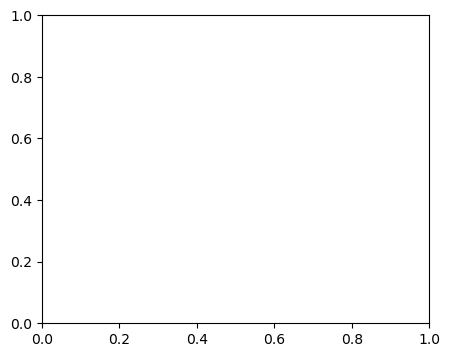

In [9]:
fig , ax = plt.subplots( 1 , figsize = ( 5 , 4 ) )
ax.plot( H.history["loss"] , label = "train loss", color = "skyblue" )
ax.plot( H.history["val_loss"] , label = "val loss", color = "orange" )
ax.set_xlabel("epoch")
ax.set_ylabel("Loss")
ax.set_title('Training histor (FFNN)')

fig.tight_layout()
plt.legend()
plt.show()

Import the trained model (if the training was not run) and compute the error over the test set and over the entire dataset.

In [10]:
# Use the following line if you want to load the pretrained model.
#model = tf.keras.models.load_model("Output/SimpleRNN_RD.h5")

#Make predictions.
print("Making the predictions:")
TEST_PRED = model.predict( TEST_IN , verbose = 0 )
TOT_PRED = model.predict( UIN.T , verbose = 0)
TEST_MSE = LOSS( TEST_PRED , TEST_OUT )
TOT_MSE = LOSS( TOT_PRED , UOUT.T)

#Print the results.
print("\n--->The MSE on the test set is: {:.3f}".format(TEST_MSE.numpy()))
print("--->The MSE on the total dataset set is: {:.3f}".format(TOT_MSE.numpy()))

Making the predictions:


NameError: name 'model' is not defined

Plot the real data, the pedictins and the training error per each snip as movies.

In [11]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

real_data = UOUT.T.reshape( T_dim - DT , X_dim , Y_dim )
predictions = TOT_PRED.reshape( T_dim - DT , X_dim , Y_dim )
error = ( UOUT.T - TOT_PRED ).reshape( T_dim - DT , X_dim , Y_dim )

total_frames = predictions.shape[0]

# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots( 1 , 3 , figsize = ( 10 , 3) , sharey = True )


labels = ['Real Data', 'Prediction', 'Error']
zz = [real_data,predictions,error]
images = []

for tt, label, z in zip(range(axes.shape[0]), labels, zz):
    vmin = np.min(z[tt, :, :])
    vmax = np.max(z[tt, :, :])
    p = axes[tt].imshow(z[tt, :, :].reshape(( X_dim , Y_dim ), order='C').T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[tt].set_title(label)
    images.append(p)
    div = make_axes_locatable(axes[tt])
    cax = div.append_axes('right', '5%', pad=0.1)
    fig.colorbar(p, cax=cax)

plt.tight_layout()


# animation function.  This is called sequentially
def animate(i, zz):
    for idx_im, (image, z) in enumerate( zip( images , zz ) ):
        image.set_array(z[ i , : , : ].reshape((X_dim, Y_dim), order='C').T)


anim = FuncAnimation(fig, lambda i: animate(i, zz), frames=total_frames, interval=5)

video_name = 'NN_predictions_RD.mp4'
anim.save(video_name, fps=total_frames/10, extra_args=['-vcodec', 'libx264'])
plt.close()

NameError: name 'UOUT' is not defined

In [12]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/pz2eLs6uKcI" title="YouTube video player" frameborder="0" 
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

Link to the video: [Neural Network predictions of the Reaction Diffusion dynamic](https://youtu.be/pz2eLs6uKcI)

## (b)

Now, we compare the trajectories of the ODE with the trajctories of the FFNN, where the trajector of the FFNN was obtained by feeding the network with its own outputs at the previous step. The video below shows clearly how the error accumulates in time.

In [13]:
FFNN_trajectory = np.zeros( UIN.shape )
FFNN_trajectory[ : , 0 ] = UIN[ : , 0 ]
APP = FFNN_trajectory[ : , 0 ]

for i in range( 1 , T_dim - 1 , 1 ):
    FFNN_trajectory[ : , i ] = model.predict( APP[None , : ] , verbose = 0) 
    APP = FFNN_trajectory[ : , i ]

NameError: name 'UIN' is not defined

In [14]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
    
real_data = UOUT.T.reshape( T_dim - 1 , X_dim , Y_dim )
predictions = FFNN_trajectory.T.reshape( T_dim - 1 , X_dim , Y_dim )
error = ( UOUT.T - FFNN_trajectory.T ).reshape( T_dim - 1 , X_dim , Y_dim )

total_frames = predictions.shape[0]

# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots( 1 , 3 , figsize = ( 10 , 3) , sharey = True )


labels = ['Real Data', 'Prediction', 'Error']
zz = [real_data,predictions,error]
images = []

for tt, label, z in zip(range(axes.shape[0]), labels, zz):
    vmin = np.min(z[tt, :, :])
    vmax = np.max(z[tt, :, :])
    p = axes[tt].imshow(z[tt, :, :].reshape(( X_dim , Y_dim ), order='C').T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axes[tt].set_title(label)
    images.append(p)
    div = make_axes_locatable(axes[tt])
    cax = div.append_axes('right', '5%', pad=0.1)
    fig.colorbar(p, cax=cax)

plt.tight_layout()


# animation function.  This is called sequentially
def animate(i, zz):
    for idx_im, (image, z) in enumerate( zip( images , zz ) ):
        image.set_array(z[ i , : , : ].reshape((X_dim, Y_dim), order='C').T)


anim = FuncAnimation(fig, lambda i: animate(i, zz), frames=total_frames, interval=5)

video_name = 'NN_predictions_RD_2.mp4'
anim.save(video_name, fps=total_frames/10, extra_args=['-vcodec', 'libx264'])
plt.close()

NameError: name 'UOUT' is not defined

In [15]:
%%HTML 
<iframe width="560" height="315" src="https://www.youtube.com/embed/29hF-toSpAI" title="YouTube video player" frameborder="0"
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

Link to the video: [Feed Forward Neural Network feed with its own output, Reaction Diffusion Equation](https://youtu.be/29hF-toSpAI)

## point (c)

In this exercise we must project the trajectories obtained via the Reaction Diffusion equation into low dimensional latent space and a train neural network to make time predictions.

In [16]:
rd_data = scipy.io.loadmat('../DATA/reaction_diffusion_big.mat')
print(rd_data.keys())
u = rd_data['u']
v = rd_data['v']
t = rd_data['t']
x = rd_data['x']
y = rd_data['y']

FileNotFoundError: [Errno 2] No such file or directory: '../DATA/reaction_diffusion_big.mat'

The SVD is calculated and the conserved energy is calculated per included eigenmode.
Then the required modes to recover $90\%, 99\%$ and $99.9\%$ of the energy are calulated.

In [17]:
X_u = np.reshape(u, (u.shape[0]*u.shape[1], u.shape[2]))
U, S, VT = np.linalg.svd(X_u, full_matrices=False)
S = np.diag(S)

NameError: name 'u' is not defined

In [18]:
E = np.zeros(U.shape[-1])
E_org = np.linalg.norm(X_u)**2 # Energy calculated as the squared Frobenius norm
for r in range(U.shape[-1]):
    # X_approx = U[:, :r+1] @ S[:r+1, :r+1] @ VT[:r+1, :]
    X_approx = U[:, :r] @ S[:r, :r] @ VT[:r, :]
    E[r] = np.linalg.norm(X_approx)**2/E_org # Energy as a fraction of the original energy

energy_targets = [0.9, 0.99, 0.999]
r_modes = np.zeros(len(energy_targets))
for i, energy_target in enumerate(energy_targets):
    r_modes[i] = np.min(np.where(E >=energy_target)[0])
    print(f"For {energy_target*100}% of the energy, {r_modes[i]+1} modes are required")

NameError: name 'U' is not defined

The first six eigenmodes are plotted.

NameError: name 'U' is not defined

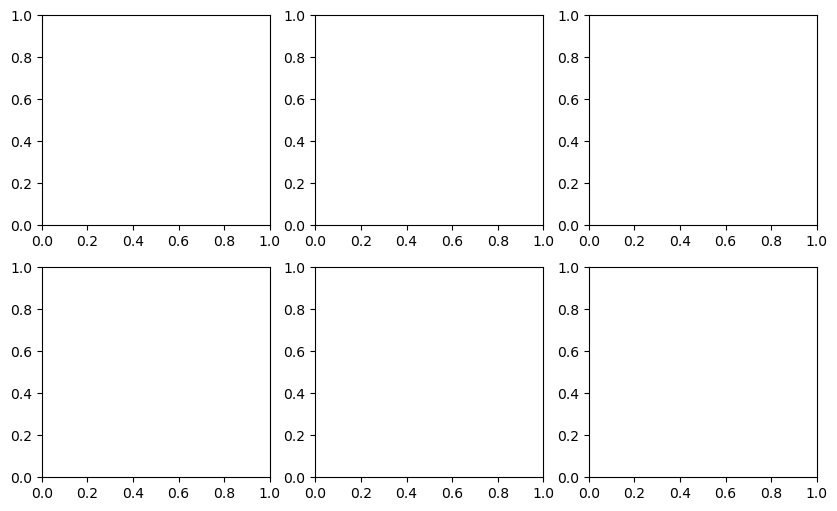

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for r, ax in enumerate(axes.ravel()):
    eigen_vector_r = U[:, r]
    ax.imshow(eigen_vector_r.reshape(u.shape[:-1], order='C').T, cmap="RdBu_r")
    ax.set_title(f"Eigen Mode {r+1}")

The amplitude of the first six eigenmodes are calculated and then plotted.

In [20]:
SVT = S @ VT
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plt.tight_layout()
for r, ax in enumerate(axes.ravel()):
    eigen_vector_r = SVT[r, :]
    ax.plot(eigen_vector_r)
    ax.set_title(f"Eigen Amplitude {r+1}")
    ax.grid()

NameError: name 'S' is not defined

Now a FFNN is trained to step forward the latent space amplitudes.

In [21]:
# Prepare the dataset.
r_modes = 6
features = SVT[:r_modes, :-1].T
targets = SVT[:r_modes, 1:].T
idx = np.arange(features.shape[0])

train_idx = idx[:int(0.8*len(idx))]
test_idx = idx[int(0.8*len(idx)):int(0.95*len(idx))]
val_idx = idx[int(0.95*len(idx)):]

feature_train = features[train_idx, :]
target_train = targets[train_idx, :]
feature_test = features[test_idx, :]
target_test = targets[test_idx, :]
feature_val = features[val_idx, :]
target_val = targets[val_idx, :]

# Implement the tensorflow model.
import tensorflow as tf
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense


model = tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=features.shape[1]),
                                    tf.keras.layers.Dense(64, activation=tf.math.log_sigmoid),
                                    tf.keras.layers.Dense(64, activation='linear'),
                                    tf.keras.layers.Dense(targets.shape[1])])  

compile_kwargs = {"loss": 'mse',
                  "optimizer": tf.keras.optimizers.Adam(1e-3)}

model.compile(**compile_kwargs)


fit_kwargs = {"epochs": 1000,
              "verbose": 0, # ! no printing of the training process (takes 18s on my machine)
              "validation_data": (feature_val, target_val)}

# Fit the model and plot the training history.
model.fit(feature_train, target_train, **fit_kwargs)
fig = plt.figure()
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show();

NameError: name 'SVT' is not defined

Plot the predictions against the real data. Looking at the funtions one would suspect that fitting a polynomial might yield better results than the current neural network. This knowledge could be implemented to chose more suitable activation functions.

In [22]:
pred = model.predict(features)
colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
plt.tight_layout()
for r, (ax, color) in enumerate(zip(axes.ravel(), colors)):
    ax.plot(t[1:], pred[:, r], color=color)
    ax.scatter(t[1:], targets[:, r], s=1.5, color=color, marker='x')
    ax.set_title(f"Eigen Amplitude {r+1}")
    ax.grid()
leg = ax.legend(['NN', 'ODE'])
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_color('black')

NameError: name 'model' is not defined

A movie of the reproduced reaction is shown below, please note that NN plot includes data from the training, test and validaton sets:

NameError: name 'SVT' is not defined

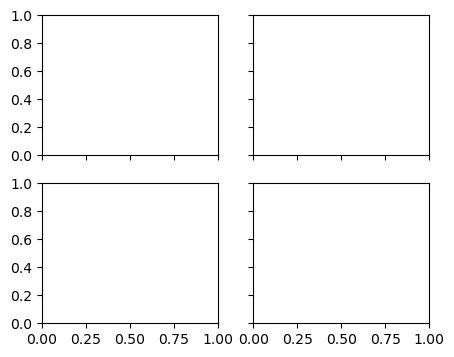

In [23]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
from mpl_toolkits.axes_grid1 import make_axes_locatable

# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)

w_k = SVT[:r_modes, 1:]
w_k_pred = model.predict(np.atleast_2d(features)).T # reshape is to make it a 2D array
X_trunc = U[:, :r_modes] @ w_k
X_trunc = U[:, :r_modes] @ w_k
X_trunc_pred = U[:, :r_modes] @ w_k_pred
zzs = [X_u[:, 1:], X_trunc, X_trunc_pred, (X_trunc - X_u[:, 1:])]

labels = ['Original', 'Truncated', 'NN Truncacted', 'Error']

extent = np.round(np.array([np.min(x), np.max(x), np.min(y), np.max(y)]), 0).astype(int)
plt.tight_layout()
images = []
for ax, zz, label in zip(axes.ravel(), zzs, labels):
    pos = ax.imshow(zz[:, 0].reshape(u.shape[:-1], order='C').T, cmap="RdBu_r", extent=extent)
    ax.set_title(label)
    images.append(pos)
axes[1, 0].set_xlabel('x')
axes[1, 1].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[1, 0].set_ylabel('y')

div = make_axes_locatable(axes[1, 1])
cax = div.append_axes('right', '5%', '5%')
cb = fig.colorbar(pos, cax=cax)

total_frames = X_trunc.shape[-1]

# animation function.  This is called sequentially
def animate(i):
    for idx_im, image in enumerate(images):
        image.set_array(zzs[idx_im][:, i].reshape(u.shape[:-1], order='C').T)
        images[idx_im] = image
    cax.cla()
    fig.colorbar(images[-1], cax=cax)
    return images

anim = FuncAnimation(fig, lambda i: animate(i), frames=total_frames, interval=(t[-1]-t[1])*1000/total_frames)

video_name = 'NN_predictions_RD_SVD.mp4'
anim.save(video_name, fps=20, extra_args=['-vcodec', 'libx264'])
plt.close()

In [24]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/FJV9dVd1i3I" title="YouTube video player" frameborder="0" 
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

Link to the video: [Feed Forward Neural Network predictions of the SVD reduced Reaction Diffusion dynamic](https://youtu.be/FJV9dVd1i3I)